In [1]:
import pandas as pd
import numpy as np
import os
import copy
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore
import torch


In [2]:
fpkm_replicates = pd.read_csv("FPKM_replicates.csv")
fpkm_replicates.head()
fpkm_replicates.shape

(33560, 48)

#Gene Data Filtering

In [ ]:
C_group = fpkm_replicates[["tracking_id"]+[col for col in fpkm_replicates.columns if "C" in col]]
S_group = fpkm_replicates[["tracking_id"]+[col for col in fpkm_replicates.columns if "S" in col]]
WT_group = fpkm_replicates[["tracking_id"]+[col for col in fpkm_replicates.columns if "WT" in col]]


def filter_data(df, min_num_of_non_zero=2):
    mask = df.apply(lambda x: x[x != 0].count(), axis=1) >= min_num_of_non_zero
    anti_mask = df.apply(lambda x: x[x != 0].count(), axis=1) < min_num_of_non_zero
    filtered = df[mask]
    removed = df[anti_mask]

    return filtered, removed

filtered_C, removed_C = filter_data(C_group)
filtered_S, removed_S = filter_data(S_group)
filtered_WT, removed_WT = filter_data(WT_group)

In [ ]:
# Get the union of filtered genes across all plant lines and removed genes

# list(set(([1,2,3,4]+[2,3,5]+[4,5,6])))  -> [1, 2, 3, 4, 5, 6]

filtered_genes_union = list(set( list(filtered_C["tracking_id"]) + list(filtered_S["tracking_id"]) + list(filtered_WT["tracking_id"])))
removed_genes = list( set(C_group["tracking_id"]) - set(filtered_genes_union))

pd.DataFrame(filtered_genes_union).to_csv("filtered_genes_union.csv")
pd.DataFrame(removed_genes).to_csv("removed_genes.csv")

len(filtered_genes_union), len(removed_genes)

# Get the dataframes after filtering and union

filtered_C, removed_C = C_group[C_group["tracking_id"].isin(filtered_genes_union)], C_group[C_group["tracking_id"].isin(removed_genes)]
filtered_S, removed_S = S_group[S_group["tracking_id"].isin(filtered_genes_union)], S_group[S_group["tracking_id"].isin(removed_genes)]
filtered_WT, removed_WT = WT_group[WT_group["tracking_id"].isin(filtered_genes_union)], WT_group[WT_group["tracking_id"].isin(removed_genes)]


# Combine all filtered Lines
filtered_all_lines = pd.DataFrame()
filtered_all_lines = pd.concat([filtered_all_lines, filtered_C], axis =1)
filtered_all_lines = pd.concat([filtered_all_lines, filtered_S[filtered_S.columns[1:]]], axis =1)
filtered_all_lines = pd.concat([filtered_all_lines, filtered_WT[filtered_WT.columns[1:]]], axis =1)

filtered_all_lines.to_excel("filtered_all_lines.xlsx", index=False)
filtered_all_lines = pd.DataFrame(pd.read_excel("filtered_all_lines.xlsx"))

In [2]:
filtered_all_lines = pd.DataFrame(pd.read_excel("filtered_all_lines.xlsx"))

#Prepare Data for RNN

In [3]:
def get_z_score(df):
    # mean = df.mean(axis=None)
    mean = df.mean().mean()
    print ("Mean", mean)
    # std = df.std(axis=None)
    std = df.stack().std()
    return (df- mean)/std

def normalize_data(df, exclude_cols=None):
    # if cols == None:
    #     cols = df.select_dtypes(np.number).columns
    all_cols = list(df.columns)
    if exclude_cols!=None:
        for i in exclude_cols:
            all_cols.remove(i)
    print (all_cols)

    df[all_cols] = get_z_score(df[all_cols])
    # df[all_cols] = minmax_scale(df[all_cols])
    min_ = df[all_cols].min().min()
    max_ = df[all_cols].max().max()

    df[all_cols] = (df[all_cols]-min_)/(max_-min_)
    return df

def normalize_data_axis(df, axis=1):
    MIN = df.min(axis)
    print (MIN)
    MAX = df.max(axis)
    # df = df.apply(zscore,axis)
    return df.sub(MIN, 1-axis).div(MAX-MIN, 1-axis)




In [4]:
lines = ["C", "S", "WT"]
# times = ["0", "15", "30", "60"]
times = ["0", "15", "30"]
replicates = ["1", "2", "3", "4"]

# sample 1 - [over times [{counts, H, RMS, P, ..}]

samples = []

entire_data = {}

# filtered_all_lines = pd.DataFrame(pd.read_excel("filtered_all_lines.xlsx"))

all_samples_names = list(filtered_all_lines.columns[1:])

avg_freq_df = pd.DataFrame(pd.read_excel("AvgFreq.xlsx"))
rms_df = pd.DataFrame(pd.read_excel("RMS.xlsx"))
peaks_df = pd.DataFrame(pd.read_excel("Peaks.xlsx"))
crest_fac_df = pd.DataFrame(pd.read_excel("CrestFactor.xlsx"))

avg_freq_df_normalized = normalize_data_axis(avg_freq_df)
rms_df_normalized = normalize_data_axis(rms_df)
peaks_df_normalized = normalize_data_axis(peaks_df)
crest_fac_df_normalized = normalize_data_axis(crest_fac_df)

#write_all_data_path = "input_data/normalized_data"

filtered_all_lines_normalized = normalize_data(filtered_all_lines, exclude_cols=["tracking_id"])

0    0.111782
dtype: float64
0    0.007604
dtype: float64
0    27.35835
dtype: float64
0    0.971151
dtype: float64
['C_0_1', 'C_0_2', 'C_0_3', 'C_0_4', 'C_15_1', 'C_15_2', 'C_15_3', 'C_15_4', 'C_30_1', 'C_30_2', 'C_30_3', 'C_30_4', 'C_60_1', 'C_60_2', 'C_60_3', 'C_60_4', 'S_0_1', 'S_0_2', 'S_0_3', 'S_0_4', 'S_15_1', 'S_15_2', 'S_15_3', 'S_15_4', 'S_30_1', 'S_30_2', 'S_30_3', 'S_30_4', 'S_60_1', 'S_60_2', 'S_60_3', 'S_60_4', 'WT_0_1', 'WT_0_2', 'WT_0_3', 'WT_0_4', 'WT_15_1', 'WT_15_2', 'WT_15_3', 'WT_30_1', 'WT_30_2', 'WT_30_3', 'WT_30_4', 'WT_60_1', 'WT_60_2', 'WT_60_3', 'WT_60_4']
Mean 32.69667309097266


In [10]:
from tqdm import tqdm
import torch
all_gene_names = filtered_all_lines_normalized["tracking_id"]
# Assuming 'all_gene_names' and 'filtered_all_lines_normalized' have been previously defined

X_S = []  # Create a new list to hold the tensor data for the 'S' line

for gene_name in tqdm(all_gene_names):

    gene_data_S = []  # Data specific to 'S' line

    for replicate in range(4):

        time_data_S = []  # Data for different time points

        for time in [0, 15, 30]:

            time_based_replicate_S = f"S_{time}_{replicate+1}"  # Modify to reflect the 'S' line data

            gene_count_S = filtered_all_lines_normalized[filtered_all_lines_normalized["tracking_id"] == gene_name][time_based_replicate_S].item()

            avg_frq_S = avg_freq_df_normalized[time_based_replicate_S].item()
            rms_S = rms_df_normalized[time_based_replicate_S].item()
            peak_S = peaks_df_normalized[time_based_replicate_S].item()
            crest_fac_S = crest_fac_df_normalized[time_based_replicate_S].item()

            time_data_S.append([gene_count_S, avg_frq_S, rms_S, peak_S, crest_fac_S])

        gene_data_S.append(time_data_S)

    X_S.append(gene_data_S)

X_torch_S = torch.Tensor(X_S)  # Convert the list to a PyTorch tensor
print(X_torch_S.shape)  # Check the shape of the created tensor


100%|██████████| 25706/25706 [21:30<00:00, 19.91it/s]


torch.Size([25706, 4, 3, 5])


In [11]:
torch.save(X_torch_S, 'X_S.pt')

In [26]:
all_gene_names = filtered_all_lines_normalized["tracking_id"]

In [12]:
from tqdm import tqdm

all_gene_names = filtered_all_lines_normalized["tracking_id"]
Y_group_indexes_S = ['S_60_1', 'S_60_2', 'S_60_3', 'S_60_4']
Y_S = []

for gene_name in tqdm(all_gene_names):
    each_sample_S = []
    for time_based_replicate_S in Y_group_indexes_S:

        gene_count_S = filtered_all_lines_normalized[filtered_all_lines_normalized["tracking_id"]==gene_name][time_based_replicate_S].item()

        Y_S.append(gene_count_S)


100%|██████████| 25706/25706 [07:28<00:00, 57.37it/s]


In [13]:
Y_torch_S = torch.Tensor(Y_S)
print (Y_torch_S.shape)

torch.Size([102824])


In [14]:
import torch

# X_torch = torch.Tensor(X)
# Y_torch = torch.Tensor(Y)
# print (X_torch.shape)
torch.save(X_torch_S, 'X_S.pt')
torch.save(Y_torch_S, 'Y_S.pt')

In [15]:
import torch
X_torch_S = torch.load('X_S.pt')
Y_torch_S = torch.load('Y_S.pt')
Y_torch_S = Y_torch_S.reshape(Y_torch_S.shape[0],1)
Y_torch_S.shape

torch.Size([102824, 1])

#RNN

#Modified LSTM

In [16]:
import torch.nn as nn
from torch.autograd import Variable
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super(ImprovedLSTM, self).__init__()

        # Added L2 regularization
        self.reg_lambda = 0.01

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Added dropout layer
        self.dropout = nn.Dropout(p=0.3)

        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Added dropout
        x = self.dropout(x)
        x = x.view(-1, self.seq_length, self.input_size)

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)  # Removed final activation for regression
        return out




In [17]:
num_epochs = 100  # 1000 epochs
learning_rate = 0.0001 # 0.001 lr

input_size = X_torch_S.shape[3]  # number of features ==5
hidden_size = 20  # number of features in hidden state
num_layers = 1  # number of stacked lstm layers

num_classes = 1  # number of output classes

seq_length = X_torch_S.shape[1] #4


In [18]:
print(input_size)

5


In [19]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the model with the appropriate arguments
lstm1 = ImprovedLSTM(input_size, hidden_size, num_layers, seq_length) #our lstm class
print(lstm1)

criterion = nn.MSELoss()

def loss_function(outputs, targets):
    loss = criterion(outputs, targets)
    l2_reg = 0

    for param in model.parameters():
        l2_reg += torch.norm(param)

    return loss + self.reg_lambda * l2_reg  # mean-squared error for regression

# Choose an optimizer (e.g., SGD or Adam)
optimizer = torch.optim.SGD(lstm1.parameters(), lr=0.001, momentum=0.9)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

ImprovedLSTM(
  (lstm): LSTM(5, 20, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_1): Linear(in_features=20, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


#Training Loop

In [20]:
print(X_torch_S.shape)
print(Y_torch_S.shape)

torch.Size([25706, 4, 3, 5])
torch.Size([102824, 1])


In [21]:
from tqdm.notebook import tqdm

Y_torch_S = Y_torch_S[:77118]
for epoch in tqdm(range(num_epochs)):
    outputs = lstm1.forward(X_torch_S) #forward pass

    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    # obtain the loss function

    # print (outputs.shape, Y_torch.shape)
    loss = criterion(outputs, Y_torch_S)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    scheduler.step(loss)
    with torch.no_grad():
        if epoch % 5 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            print("RMSE:", np.sqrt(loss.item()))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, loss: 0.00212
RMSE: 0.04599124322005784
Epoch: 5, loss: 0.00185
RMSE: 0.043007479628696166
Epoch: 10, loss: 0.00138
RMSE: 0.03708485527349993
Epoch: 15, loss: 0.00091
RMSE: 0.03015090579092998
Epoch: 20, loss: 0.00055
RMSE: 0.02354405069855693
Epoch: 25, loss: 0.00033
RMSE: 0.018152493367533846
Epoch: 30, loss: 0.00021
RMSE: 0.014465482425310278
Epoch: 35, loss: 0.00015
RMSE: 0.012289674669773704
Epoch: 40, loss: 0.00012
RMSE: 0.011093153422267082
Epoch: 45, loss: 0.00011
RMSE: 0.010452528066315893
Epoch: 50, loss: 0.00010
RMSE: 0.010142192516869644
Epoch: 55, loss: 0.00010
RMSE: 0.009945790025966593
Epoch: 60, loss: 0.00010
RMSE: 0.009809608429136413
Epoch: 65, loss: 0.00009
RMSE: 0.009721455673240625
Epoch: 70, loss: 0.00009
RMSE: 0.009687037083766456
Epoch: 75, loss: 0.00009
RMSE: 0.009660383973646002
Epoch: 80, loss: 0.00009
RMSE: 0.009625029274254255
Epoch: 85, loss: 0.00009
RMSE: 0.009605128577360024
Epoch: 90, loss: 0.00009
RMSE: 0.009589766917362788
Epoch: 95, loss: 0

[0.]


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


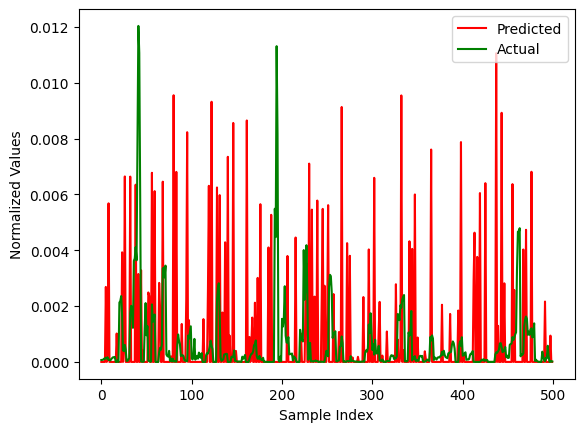

In [24]:
# Import necessary libraries and functions
import torch.optim as optim
import torch.utils.data as data
from scipy.stats import zscore

# Define a function to calculate Z-scores for data
def get_z_score(df):
    mean = df.mean().mean()
    std = df.stack().std()
    return (df - mean) / std

# Define a function to normalize data
def normalize_data(df, exclude_cols=None):
    all_cols = list(df.columns)
    if exclude_cols:
        for col in exclude_cols:
            all_cols.remove(col)

    df[all_cols] = get_z_score(df[all_cols])
    min_ = df[all_cols].min().min()
    max_ = df[all_cols].max().max()
    df[all_cols] = (df[all_cols] - min_) / (max_ - min_)
    return df

# Define a function to normalize data along a specified axis
def normalize_data_axis(df, axis=1):
    MIN = df.min(axis)
    MAX = df.max(axis)
    return df.sub(MIN, 1 - axis).div(MAX - MIN, 1 - axis)

# Load and preprocess your data using these functions
filtered_all_lines_temp = filtered_all_lines[filtered_all_lines.columns[1:]]
std = filtered_all_lines_temp.stack().std()
mean = filtered_all_lines_temp.mean().mean()
Min = filtered_all_lines_temp.min().min()
Max = filtered_all_lines_temp.max().max()

predicted_values = []

with torch.no_grad():
    predicted_values = lstm1.forward(X_torch_S)
    predicted_values = predicted_values.numpy()

predicted_values = predicted_values[:77118]

print(predicted_values[100])

# Normalize the predicted values
# normalized = predicted_values
# for i in range(len(normalized)):
#     normalized[i] = (normalized[i] - Min) / (Max - Min)

# Example of plotting using matplotlib
import matplotlib.pyplot as plt

to_num = 500
pred_pres = predicted_values[:to_num] #changed from normalized[:to_num]
x_coords = [i for i in range(to_num)]

actuals = []
for i in range(len(Y_torch_S)):
    actuals.append(Y_torch_S[i])

actuals = actuals[:to_num]

plt.plot(x_coords, pred_pres, color="red", label="Predicted")
plt.plot(x_coords, actuals, color="green", label="Actual")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Values")
plt.legend()
plt.show()


In [ ]:
# test to check values, with input data only

import matplotlib.pyplot as plt
# %matplotlib inline

sample = X[1]
predicted_values = []

with torch.no_grad():
    # for sample in X:
    predicted_values = lstm1.forward(torch.Tensor(X))
    predicted_values = predicted_values.numpy()
        # .data.numpy()
        # predicted_values.append(predicted_values)
# predicted_values= predicted_values.reshape(len(Y),).tolist()
print (len(predicted_values))

NameError: ignored

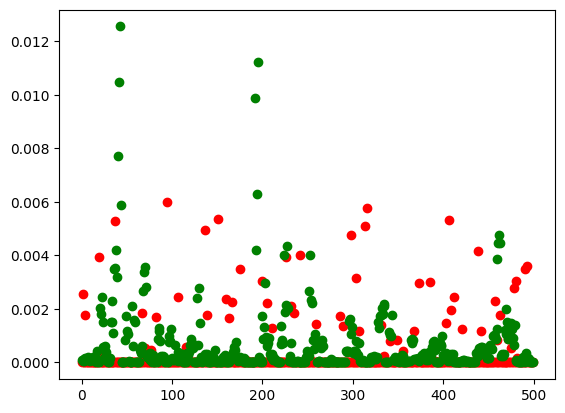

In [ ]:
to_num = 500

pred_pres = predicted_values[:to_num]
x_coords = [i for i in range(to_num)]
actual = Y_torch[:to_num]

plt.plot(x_coords, pred_pres, 'o', color = "red")
plt.plot(x_coords, actual , 'o', color = "green")
# plt.plot(len(Y), Y)


In [27]:
gene_names_rmse = []

for i, gene_name in enumerate(all_gene_names):
  rmse = np.sqrt(np.mean((predicted_values[i] - Y_torch_S[i].numpy())**2))
  gene_rmse = (gene_name, rmse)
  gene_names_rmse.append(gene_rmse)

# gene_names_rmse is now a list of tuples (gene_name, rmse)

In [28]:
import csv

gene_names_rmse = []

for i, gene_name in enumerate(all_gene_names):
  rmse = np.sqrt(np.mean((predicted_values[i] - Y_torch_S[i].numpy())**2))
  gene_rmse = (gene_name, rmse)
  gene_names_rmse.append(gene_rmse)

with open('gene_rmse_S_Line.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['Gene Name', 'RMSE']) # Column headers
  for row in gene_names_rmse:
    writer.writerow(row) # Each row is a tuple